In [45]:
import os
import rasterio
from rasterio.plot import show
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

#### Read in vector file of polygon zones

     HYBAS_ID  NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  8030000010          0  8030000010  8030000010        0.0        0.0   
1  8030005510          0  8030005510  8030005510        0.0        0.0   
2  8030009560          0  8030009560  8030009560        0.0        0.0   
3  8030010700          0  8030010700  8030010700        0.0        0.0   
4  8030016860          0  8030016860  8030016860        0.0        0.0   

    SUB_AREA    UP_AREA  PFAF_ID SIDE  LAKE  ENDO  COAST  ORDER  SORT  \
0   583011.4   583011.4      811    M     0     0      1      0     1   
1   832819.3   832828.8      812    M     0     0      0      1     2   
2  1795626.7  1795841.4      822    M     0     0      0      1     5   
3   549425.8   549425.8      831    M     0     0      1      0     7   
4   492169.6   492169.6      832    M     0     0      1      0     8   

   OBJECTID           Region    Shape_Leng    Shape_Area  \
0         1  Extended Region  4.184674e+07  2.259954e+12

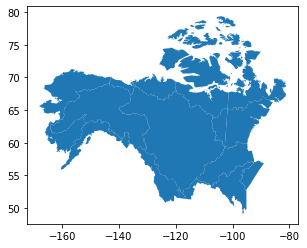

In [55]:
%%time
# Get the shp filename
shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg'
vector_gdf = gpd.read_file(shp_fn) 
print(vector_gdf.head())
vector_gdf.plot()

vector_file_name = 'bioclimate_dd'
vector_file_name = 'hybas_lev03'

zone_field_name = 'zone_'
zone_field_name = 'HYBAS_ID'

#### Specify raster file

In [38]:
indir = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio'
outdir = '/att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip'
r_fn = os.path.join(indir, 'wc2.0_bio_30s_05.tif')


### Approach 1 (complicated?, but handles clipping and saving)
#### Iterate over polygon features of a vector file, clip raster by each feature, summarize raster values and save as CSV
##### This lets you clip by a bunch of features in a polygon vector - not by each indiv feature
https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html#clipping-a-raster
##### Below adapts this, looping over each feature in 'shapes'

##### First, get a geoms list of the features

/att/gpfsfs/home/appmgr/app/jupyterhub/ilab/ilab-kernel/lib/python3.7/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


# of indiv features: 29


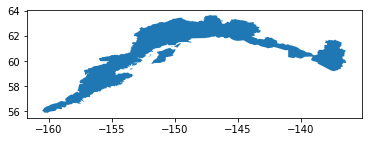

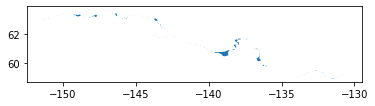

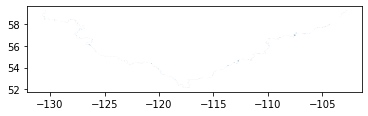

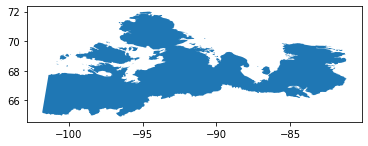

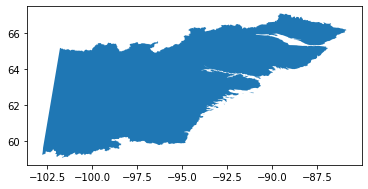

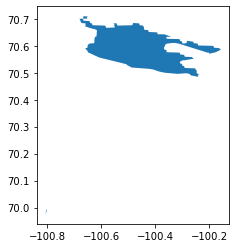

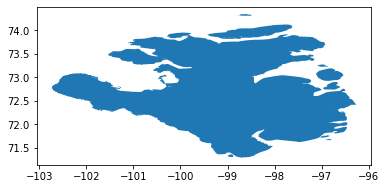

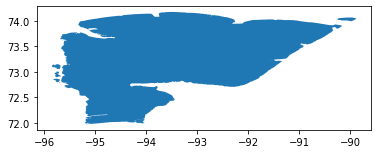

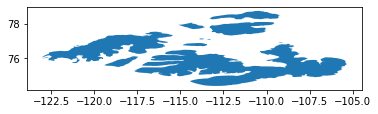

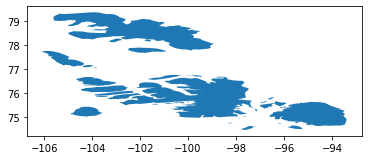

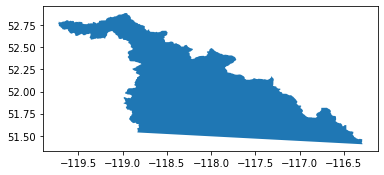

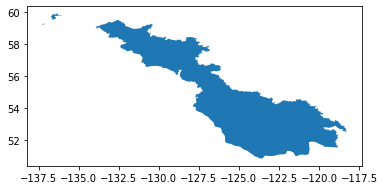

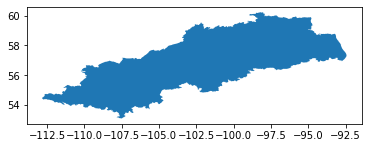

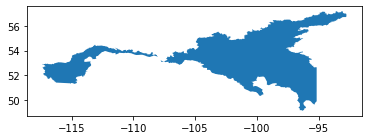

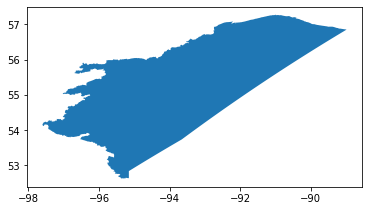

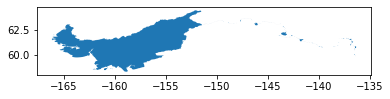

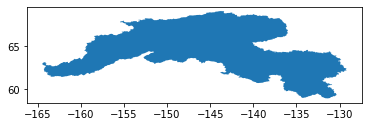

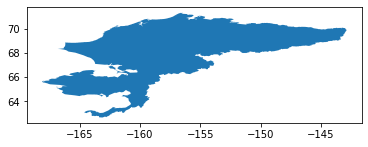

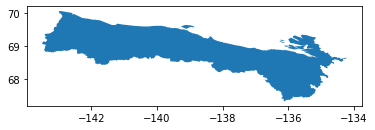

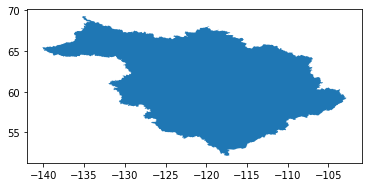

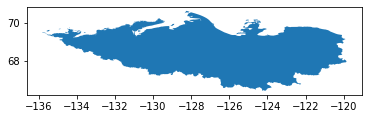

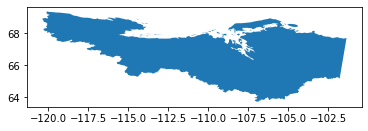

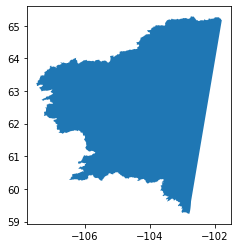

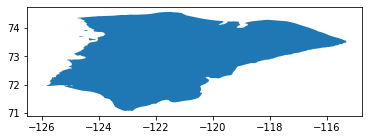

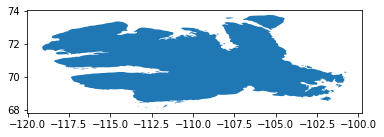

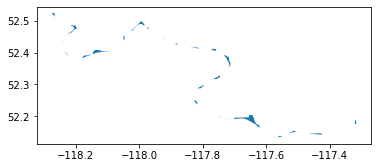

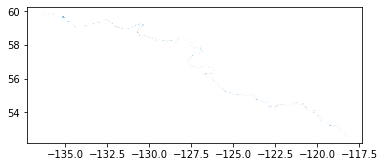

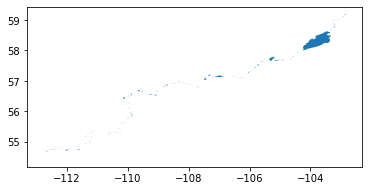

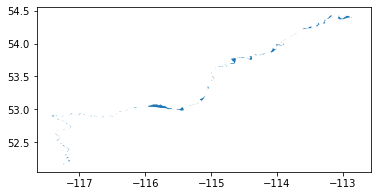

In [68]:

geoms_list = []
zone_name_list = []

for idx in vector_gdf.index:
    #print(idx)
    geom =  vector_gdf.loc[idx].geometry
    zonename =  vector_gdf.loc[idx][zone_field_name]
    
    if geom not in geoms_list:
        gpd.GeoSeries(geom).plot()
        geoms_list.append(geom)
        zone_name_list.append(zonename)

print(f'# of indiv features: {len(geoms_list)}')

In [75]:
SHOW_CLIP = False

feature_fail_list = []
no_raster_intersection_list = []

with rasterio.open(r_fn, "r") as r:
    
    ##with fiona.open(shp_fn, "r") as vectorfile:

        ##shapes = [feature["geometry"] for feature in vectorfile]
        #print(shapes[0])
        
        ##for i, shp in enumerate(shapes):
        
    for idx, zone_name in enumerate(zone_name_list):
        print(zone_name)
        geom = geoms_list[idx]
        
        try:
            feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
            #feature_gdf.plot(zone_name)
        except ValueError:
            print(f"Cant get geodataframe for feature {zone_name}")
            feature_fail_list.append(zone_name)

        # Reproject feature_gdf to raster crs
        feature_gdf = feature_gdf.to_crs(r.crs)

        zone_name = f'{zone_name:03}'
        out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace('.tif', '_'+vector_file_name+'_'+zone_name+'.tif'))

        try:

            out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

            # Copy the metadata
            out_meta = r.meta.copy()
            out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "crs":r.crs.to_proj4()}
                             )
            with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                out_r.write(out_image)

                print("Zone", zonenum, "clip of",  os.path.split(r_fn)[1])
                print("Writing clipped subset to", out_r_fn)
                
                #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?
             
            # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
            if SHOW_CLIP:
                show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

        except ValueError:
            print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
            no_raster_intersection_list.append(zone_name)

print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

8030000010
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030000010.tif
8030005510
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030005510.tif
8030009560
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030009560.tif
8030010700
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030010700.tif
8030016860
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writing clipped subset to /att/gpfsfs/briskfs01/ppl/pmontesa/tmp/test_raster_zonal_clip/wc2.0_bio_30s_05_hybas_lev03_8030016860.tif
8030024130
Zone 7030022240 clip of wc2.0_bio_30s_05.tif
Writ

### Approach 2 (simpler?, but doesnt handle clipping)
##### This zonalstats approach should return a table of counts for each categorical raster value for each vector polygon 'zone'

In [1]:
import rasterstats
from rasterstats import zonal_stats

zs = zonal_stats(shp_fn, r_fn, categorical=True)

ModuleNotFoundError: No module named 'rasterstats'